**In this Notebook we will design the full graph using 3 tools: search_tool, RAG tool, and SQL-agent for travel database**

In [1]:
from langchain_chroma import Chroma
import os
from pyprojroot import here
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

load_dotenv()

True

**Load the environment variables and the necessary configs**

In [2]:
os.environ['OPENAI_API_KEY'] = os.getenv("OPEN_AI_API_KEY")
os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")

EMBEDDING_MODEL = "text-embedding-3-small"
VECTORDB_DIR = "data/vectordb"
DOC_DIR = "data/unstructured_docs"

### **1. initialize The tools**

**1.1 RAG tool design**

In [3]:
@tool
def lookup_policy(query: str)->str:
    """Consult the company policies to check whether certain options are permitted."""
    vectordb = Chroma(
    collection_name="rag-chroma",
    persist_directory=str(here(VECTORDB_DIR)),
    embedding_function=OpenAIEmbeddings(model=EMBEDDING_MODEL)
    )
    docs = vectordb.similarity_search(query, k=2)
    return "\n\n".join([doc.page_content for doc in docs])

print(lookup_policy)

name='lookup_policy' description='Consult the company policies to check whether certain options are permitted.' args_schema=<class 'pydantic.v1.main.lookup_policySchema'> func=<function lookup_policy at 0x000001D0F8661DA0>


Test the RAG tool

In [5]:
lookup_policy.invoke("can I cancel my ticket?")

"cancel your Swiss Airlines flight within 24 hours, you can do so easily online. Just remember to check the terms and\nconditions of your ticket to make sure you're eligible for a refund.\nSwiss Air Cancellation Fees The cancellation fees for Swiss Air flights may vary depending on the type of ticket you have\npurchased. The airline of fers three dif ferent types of tickets, which are:\nFlex T icket - This ticket of fers the most flexibility and allows passengers to make changes or cancel their flight without\nincurring any additional fees. Standard T icket - This ticket of fers some flexibility but charges a fee for changes and\ncancellations. The fee for cancelling a standard ticket can range from 100 to 250 CHF , depending on the route and time\nof cancellation. Economy T icket - This ticket of fers the least flexibility and charges a fee for any changes or cancellations.\nThe fee for cancelling an economy ticket can range from 150 to 350 CHF , depending on the route and time of\nca

**1.2 Search tool design**

In [4]:
search_tool = TavilySearchResults(max_results=2)
print(search_tool.description)

A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.


Test the Search Tool

In [8]:
search_tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state ..."}]

**1.3 SQL agent tool design**

In [5]:
from langchain_community.utilities import SQLDatabase
from langchain.chains import create_sql_query_chain
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_openai import ChatOpenAI

**SQL agent chain**

In [6]:
sqldb_directory = here("data/travel.sqlite")

sql_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
# llm = ChatOpenAI(model="gpt-4o-mini")
# llm = ChatOpenAI(model="gpt-4o")
system_role = """Given the following user question, corresponding SQL query, and SQL result, answer the user question.\n
    Question: {question}\n
    SQL Query: {query}\n
    SQL Result: {result}\n
    Answer:
    """
db = SQLDatabase.from_uri(
    f"sqlite:///{sqldb_directory}")

execute_query = QuerySQLDataBaseTool(db=db)
write_query = create_sql_query_chain(
    sql_llm, db)
answer_prompt = PromptTemplate.from_template(
    system_role)


answer = answer_prompt | sql_llm | StrOutputParser()
chain = (
    RunnablePassthrough.assign(query=write_query).assign(
        result=itemgetter("query") | execute_query
    )
    | answer
)
# Test the chain
# message = "How many tables do I have in the database? and what are their names?"
# response = chain.invoke({"question": message})

In [7]:
@tool
def query_sqldb(query):
    """Query the Swiss Airline SQL Database and access all the company's information. Input should be a search query."""
    response = chain.invoke({"question": query})
    return response

In [13]:
message = "How many tables do I have in the database? and what are their names?"
response = query_sqldb.invoke(message)
print(response)

'You have 11 tables in the database. Their names are: aircrafts_data, airports_data, boarding_passes, bookings, flights, seats, ticket_flights, tickets, car_rentals, hotels, and trip_recommendations.'

**Wrap up the tools into a list**

In [8]:
tools = [search_tool, lookup_policy, query_sqldb]

#### **Load the LLM for the primary agent and bind it with the tools**

In [9]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
# Tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

### **2. Initialize the Graph State**

In [10]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

### **3. Define the Graph Nodes**

**3.1 First node: chatbot**

In [11]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Next, we need to create a function that will run the tools when they are needed. To do this, we'll add the tools to a new node.

In the example below, we'll build a BasicToolNode. This node will check the latest message and, if it contains a request to use a tool, it will run the appropriate tool. This works because many language models (like Anthropic, OpenAI, and Google Gemini) support tool usage.

**3.2 Second node: BasicToolNode that runs the appropriate tool based on the primary agent's output**

In [12]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[search_tool, lookup_policy, query_sqldb])
graph_builder.add_node("tools", tool_node)

### **4. Define the entry point and graph edges**

In [13]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

### **5. Compile the graph**

- In this step, we can add a memory to our graph as well.

In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

**5.1 Plot the compiled graph**

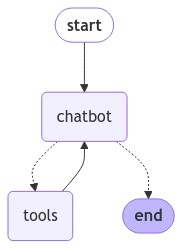

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

**Save the graph image**

In [16]:
save = False

if save:
    from PIL import Image as PILImage
    import io
    # Assuming graph.get_graph().draw_mermaid_png() returns PNG binary data
    try:
        # Generate the PNG image from the graph
        png_data = graph.get_graph().draw_mermaid_png()
        
        # Convert the binary data into an image
        img = PILImage.open(io.BytesIO(png_data))
        
        # Save the image locally with 300 DPI
        img.save('output_image.png', 'PNG', dpi=(300, 300))
        
        print("Image saved successfully with 300 DPI.")
    except Exception as e:
        print(f"Error: {e}")

### **6. Execute the graph**

In [17]:
config = {"configurable": {"thread_id": "1"}}

In [18]:
user_input = "Hi there! My name is Farzad."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Farzad.
================================== Ai Message ==================================

Hello Farzad! How can I assist you today?


In [20]:
user_input = "Can I cancel my ticket 10 hours before the flight?"

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Can I cancel my ticket 10 hours before the flight?
================================== Ai Message ==================================
Tool Calls:
  lookup_policy (call_HbQaZ6OIZZINPnEWWuNrq5Zh)
 Call ID: call_HbQaZ6OIZZINPnEWWuNrq5Zh
  Args:
    query: cancel ticket 10 hours before flight
================================= Tool Message =================================
Name: lookup_policy

"hour cancellation policy that allows passengers to cancel their flights within 24 hours of booking at +1-877-507-7341\nwithout penalty . This policy applies to all fare types, including non-refundable tickets. If you cancel your Swiss Airlines\nflight within 24 hours of booking, you'll receive a full refund of your ticket price.\nHow to Cancel Swiss Airlines Flight within 24 Hours? If you need to cancel your Swiss Airlines flight within 24 hours of\nbooking, you can do so easily online. Here are the steps to follow:\nGo t

In [21]:
user_input = "Right now Harris vs. Trump Presidential Debate is being boradcasted. I want the youtube link to this debate"

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Right now Harris vs. Trump Presidential Debate is being boradcasted. I want the youtube link to this debate
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_o0r8IBJdxqPikDoBG42PdCEj)
 Call ID: call_o0r8IBJdxqPikDoBG42PdCEj
  Args:
    query: Harris vs. Trump Presidential Debate YouTube link
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.pbs.org/newshour/politics/watch-live-harris-and-trump-debate-pbs-news-simulcast-of-abcs-2024-presidential-debate", "content": "WATCH: Harris and Trump debate \u2014 PBS News simulcast of ABC\u2019s 2024 Presidential Debate Vice President Kamala Harris and former President Donald Trump faced off Tuesday night for their first and possibly only debate before Election Day. The state of the race as they meet in 

In [17]:
user_input = "yes try that"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

yes try that
================================== Ai Message ==================================
Tool Calls:
  query_sqldb (call_joWfQ3LxgyHPYgyZpQnVslHh)
 Call ID: call_joWfQ3LxgyHPYgyZpQnVslHh
  Args:
    query: SELECT SUM(pgsize) FROM dbstat WHERE name='airports_data';
================================= Tool Message =================================
Name: query_sqldb

"The error message indicates that the table named \"dbstat\" does not exist in the database. This could be due to a typo in the table name or the table not being created in the database. Make sure that the table \"dbstat\" exists in the database before running the query."
================================== Ai Message ==================================
Tool Calls:
  query_sqldb (call_bbpPSUdSRizC6e3zdB5KH525)
 Call ID: call_bbpPSUdSRizC6e3zdB5KH525
  Args:
    query: PRAGMA page_count;
================================= Tool Message ===========

In [80]:
event

{'messages': [HumanMessage(content='Hi there! My name is Will.', id='51a728e2-0e09-42e3-a5ec-0fe57089e693'),
  AIMessage(content='Hello Will! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 124, 'total_tokens': 135}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_483d39d857', 'finish_reason': 'stop', 'logprobs': None}, id='run-381ae9b9-e371-49a2-8c7b-c5bf6ac7914b-0', usage_metadata={'input_tokens': 124, 'output_tokens': 11, 'total_tokens': 135}),
  HumanMessage(content='Can I cancel my ticket 10 hours before the flight?', id='454931d7-2412-4022-986e-1ad8e731f2f8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qjDGZJ4PCUsSzPvsu8YNbR8w', 'function': {'arguments': '{"query":"cancel ticket 10 hours before flight"}', 'name': 'lookup_policy'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tok